# Energy Consumption Forecasting

### Data Source: Kaggle

## Introduction

This dataset contains hourly estimated energy consumption in megawatts (MW) from 2019 to 2024 for the east region in the United States.

Project Goal

1. Timeseries forecasting using XGBoost model.
   
3. Create a model with at least 90% Prediction Accuracy.

## Importing Libraries

In [54]:
# Data Structure
import pandas as pd
import numpy as np

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree
from sklearn.preprocessing import LabelEncoder


# Others
color_pal = sns.color_palette()
import warnings
warnings.filterwarnings("ignore")

## Loading The Dataset

In [119]:
df = pd.read_csv(r"C:\Users\Henry Oguns\Desktop\New folder\electricityConsumptionAndProductioction.csv")
df.head()

,DateTime,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
0,2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
1,2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2,2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
3,2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
4,2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30


In [120]:
df.shape

(46011, 10)

The dataset contains 46,011 oservations and 10 Features

In [121]:
# Understandin the data type of each columns

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46011 entries, 0 to 46010
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   DateTime       46011 non-null  object
 1   Consumption    46011 non-null  int64 
 2   Production     46011 non-null  int64 
 3   Nuclear        46011 non-null  int64 
 4   Wind           46011 non-null  int64 
 5   Hydroelectric  46011 non-null  int64 
 6   Oil and Gas    46011 non-null  int64 
 7   Coal           46011 non-null  int64 
 8   Solar          46011 non-null  int64 
 9   Biomass        46011 non-null  int64 
dtypes: int64(9), object(1)
memory usage: 3.5+ MB


In [122]:
# Changing the Datetime column to a date time data type and making it the index of the dataset

df = df.set_index("DateTime")
df.index = pd.to_datetime(df.index)
df.head()

,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
DateTime,,,,,,,,,
2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30


In [123]:
Renaming the consumption column as load.

df.rename(columns = {'Consumption':'load'}, inplace = True)
df.columns

Index(['load', 'Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas',
       'Coal', 'Solar', 'Biomass'],
      dtype='object')

In [124]:
# Making a dataframe of the timeseries index and load column

df = df[['load']]
df.head()

,load
DateTime,
2019-01-01 00:00:00,6352
2019-01-01 01:00:00,6116
2019-01-01 02:00:00,5873
2019-01-01 03:00:00,5682
2019-01-01 04:00:00,5557


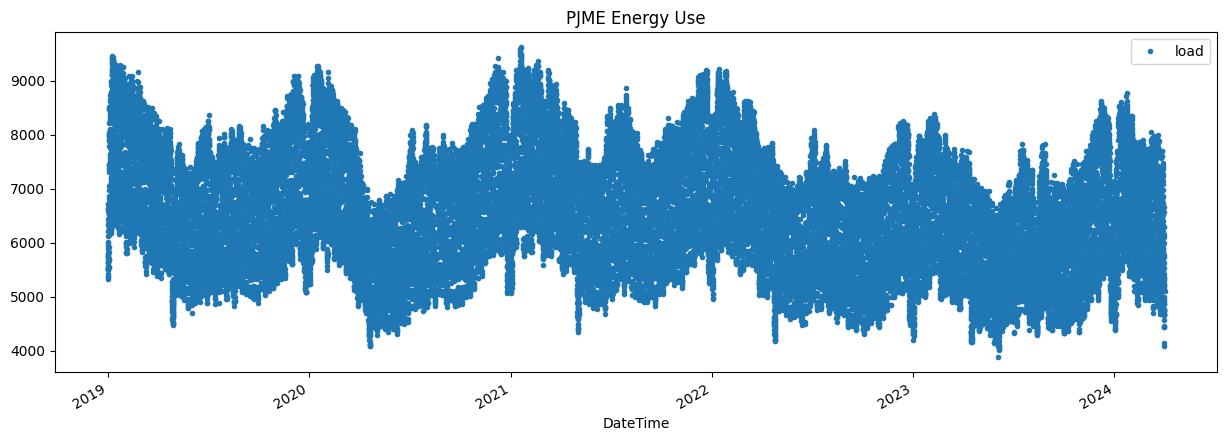

In [125]:
df.plot(style = ".", figsize=(15,5), color = color_pal[0], title = "PJME Energy Use")
plt.show()

## Training/ Test Samples Splits

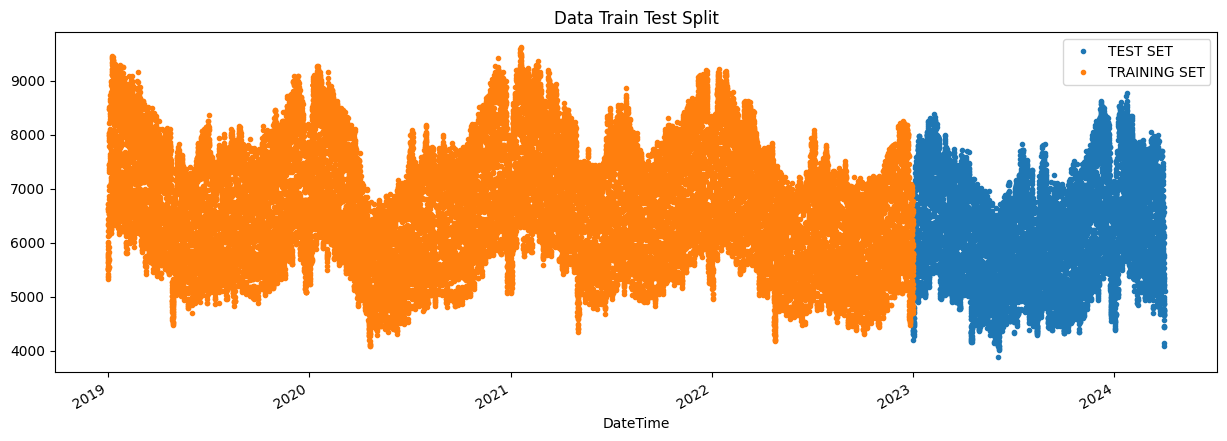

In [126]:
split_date = '01-01-2023'
train = df.loc[df.index <= split_date].copy()
test = df.loc[df.index > split_date].copy()

test \
    .rename(columns={'load': 'TEST SET'}) \
    .join(train.rename(columns={'load': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title="Data Train Test Split", style='.');

## Features Engineering

In [127]:
# Create features from datetime index
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    #df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour', 'dayofweek','month', 'quarter', 'year', 'dayofyear',
            'dayofmonth']]
    if label:
        y = df[label]
        return X, y
    return X

In [128]:
X_train, y_train = create_features(train, label='load')
X_test, y_test = create_features(test, label='load')

## Build XGBoost Model

In [129]:
reg = XGBRegressor(base_score = 0.5, booster = 'gbtree', 
                    n_estimators = 1000, early_stopping_rounds = 50,
                    objective = 'reg:linear', max_depth = 3,
                        learning_rate = 0.01)
reg.fit(X_train, y_train,
        eval_set = [(X_train, y_train), (X_test, y_test)],
        verbose = 100)

[0]	validation_0-rmse:6727.98696	validation_1-rmse:6179.75467
[100]	validation_0-rmse:2528.19476	validation_1-rmse:1943.33163
[200]	validation_0-rmse:1050.61646	validation_1-rmse:647.43629
[300]	validation_0-rmse:583.25853	validation_1-rmse:544.27233
[310]	validation_0-rmse:561.59752	validation_1-rmse:551.91624


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

## Feature Importances

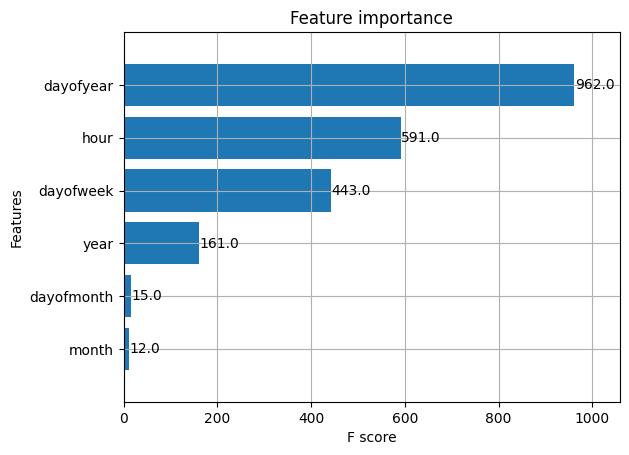

In [130]:
plot_importance(reg, height=0.8);

## Forecast on Test Set

In [131]:
test['load_Prediction'] = reg.predict(X_test)

In [132]:
test.head()

,load,date,hour,dayofweek,month,quarter,year,dayofyear,dayofmonth,load_Prediction
DateTime,,,,,,,,,,
2023-01-01 01:00:00,4995,2023-01-01 01:00:00,1,6,1,1,2023,1,1,5107.167480
2023-01-01 02:00:00,4816,2023-01-01 02:00:00,2,6,1,1,2023,1,1,5032.768555
2023-01-01 03:00:00,4627,2023-01-01 03:00:00,3,6,1,1,2023,1,1,5032.768555
2023-01-01 04:00:00,4581,2023-01-01 04:00:00,4,6,1,1,2023,1,1,5032.768555
2023-01-01 05:00:00,4535,2023-01-01 05:00:00,5,6,1,1,2023,1,1,5032.768555


In [133]:
load_all = pd.concat([test, train], sort = False)

In [134]:
load_all.shape

(46011, 10)

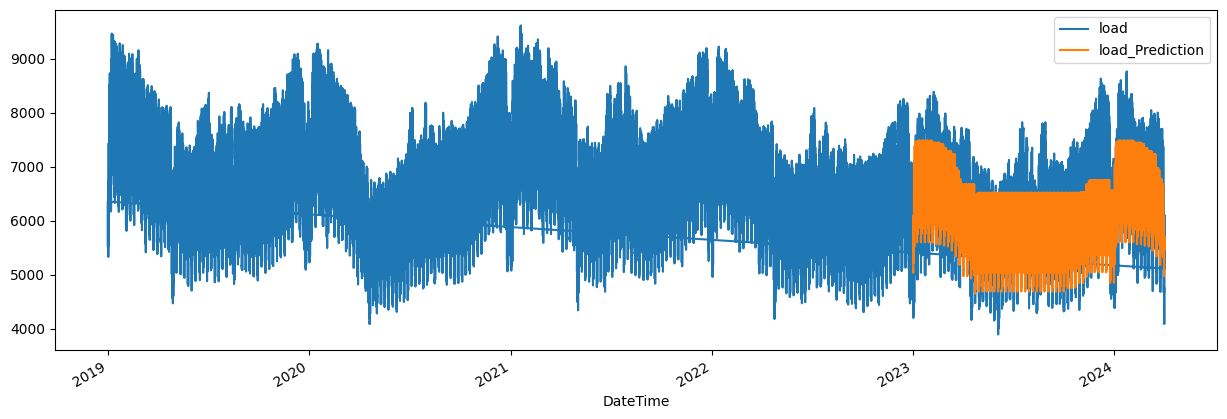

In [135]:
load_all[['load', 'load_Prediction']].plot(figsize=(15,5));

## Check first month of predictions

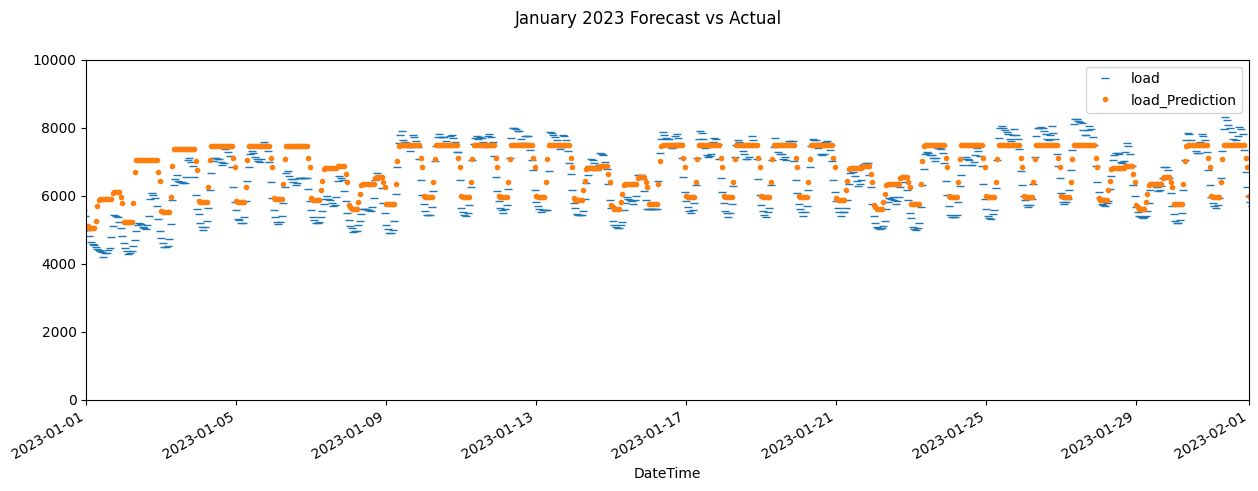

In [156]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

_ = load_all[['load', 'load_Prediction']].plot(ax=ax, style=['_', '.'])
ax.set_xbound(lower='01-01-2023', upper='02-01-2023')
ax.set_ylim(0, 10000)

plot = plt.suptitle('January 2023 Forecast vs Actual')

## Check first week of January Predictions

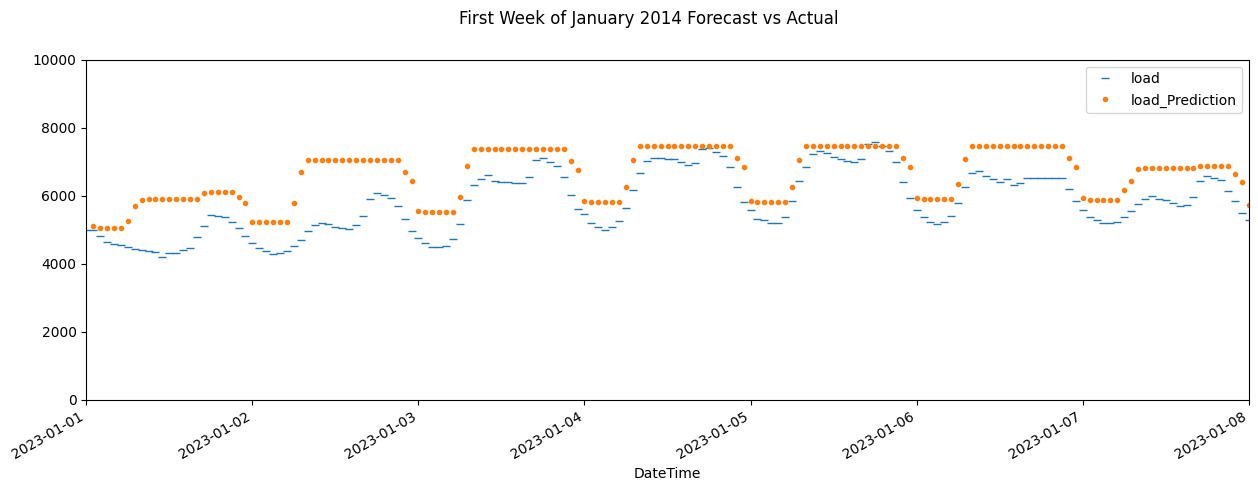

In [153]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

_ = load_all[['load', 'load_Prediction']].plot(ax=ax, style=['_', '.'])
ax.set_xbound(lower='01-01-2023', upper='01-08-2023')
ax.set_ylim(0, 10000)

plot = plt.suptitle('First Week of January 2014 Forecast vs Actual')

## Check first week of June predictions

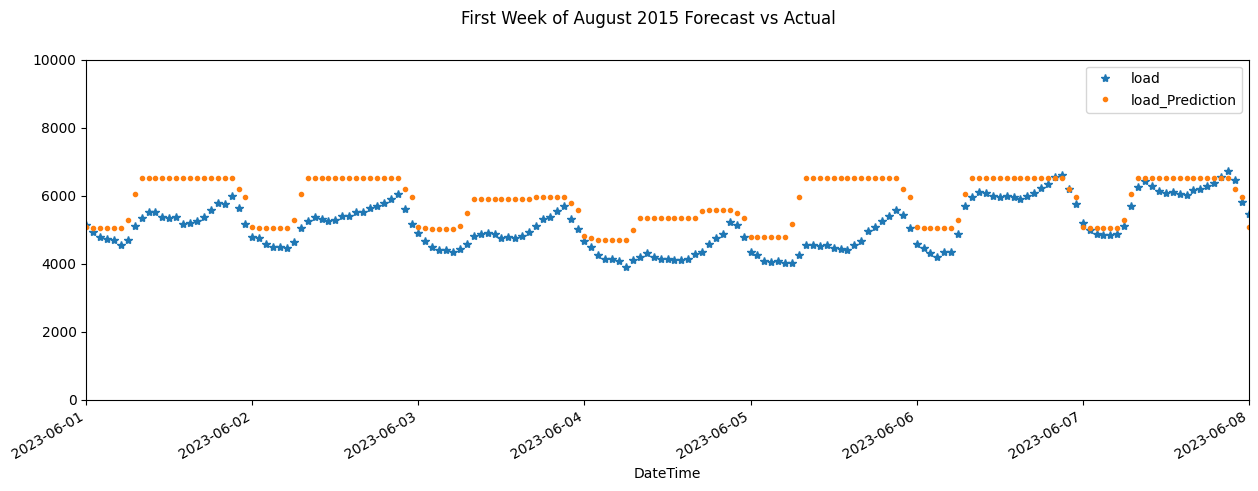

In [161]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

_ = load_all[['load', 'load_Prediction']].plot(ax=ax, style=['*', '.'])
ax.set_xbound(lower='06-01-2023', upper='06-08-2023')
ax.set_ylim(0, 10000)

plot = plt.suptitle('First Week of August 2015 Forecast vs Actual')

## Evaluate the Performance

In [162]:
# Measuring the Mean Absolute Percentage Error

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [163]:
# Making predictions using the training and testing set

y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

In [164]:
print('R^2   train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred),
                                       r2_score(y_test, y_test_pred)))

print('MSE   train: %.2f, test: %.2f' %
      (mean_squared_error(y_train, y_train_pred),
       mean_squared_error(y_test, y_test_pred)))

print('RMSE  train: %.2f, test: %.2f' %
      (np.sqrt(mean_squared_error(y_train, y_train_pred)),
       np.sqrt(mean_squared_error(y_test, y_test_pred))))

print('MAE   train: %.2f, test: %.2f' %
      (mean_absolute_error(y_train, y_train_pred),
       mean_absolute_error(y_test, y_test_pred)))

print('MAPE  train: %.2f, test: %.2f' %
      (mean_absolute_percentage_error(y_train, y_train_pred),
       mean_absolute_percentage_error(y_test, y_test_pred)))

R^2   train: 0.54, test: 0.69
MSE   train: 491950.95, test: 276642.53
RMSE  train: 701.39, test: 525.97
MAE   train: 567.82, test: 401.38
MAPE  train: 8.02, test: 6.60


The Mean absolute percent accuracy (MAPA) is 93.4% (100 - 6.60)

## Check Best and Worst Predicted Day

In [169]:
test['error'] = test['load'] - test['load_Prediction']

In [170]:
test['abs_error'] = test['error'].apply(np.abs)

In [172]:
error_by_day = test.groupby(['year','month','dayofmonth']) \
    .mean()[['load', 'load_Prediction', 'error', 'abs_error']]

In [173]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

load  load_Prediction        error    abs_error
year month dayofmonth                                                        
2024 1     1           4969.500000      6460.741699 -1491.241659  1503.804036
2023 1     2           5064.125000      6485.680176 -1421.555135  1421.555135
     4     17          4778.166667      6169.822754 -1391.656148  1391.656148
     6     5           4605.625000      5961.751953 -1356.126709  1356.126709
2024 1     2           5331.166667      6544.302734 -1213.136190  1213.136190
2023 5     1           4913.625000      5961.751953 -1048.126709  1048.126709
     1     1           4714.826087      5713.184082  -998.357889   998.357889
     12    26          5131.583333      6100.904297  -969.321248   969.321248
           25          5104.416667      6024.357422  -919.940531   955.565857
     4     16          4493.333333      5376.414551  -883.081034   883.081034

From the data, we observe that:

    number 1 worst day, January 1st, 2024 is a holiday
    number 7 worst day, January 1st, 2023, is a holiday.
    number 8 worst day, December 26th, 2023, is a holiday.
    number 9 worst day, December 25th, 2023, is a holiday.
    
Our model may benefit from adding a holiday indicator

In [174]:
# Best absolute predicted days

error_by_day.sort_values('abs_error', ascending=True).head(10)

load  load_Prediction      error   abs_error
year month dayofmonth                                                     
2023 6     27          6056.791667      6039.754395  17.037415  134.863790
     5     17          6082.125000      6039.754395  42.370748  137.498067
     6     28          6074.875000      6039.754395  35.120748  138.519714
     8     31          6097.458333      6039.754395  57.704081  141.712667
     5     8           6003.583333      5961.751953  41.831624  145.749634
     6     25          5168.541667      5199.740723 -31.198934  146.754801
           17          5674.916667      5631.671875  43.244975  147.281026
     5     16          5989.666667      6039.754395 -50.087585  147.376689
     7     3           5929.666667      5961.751953 -32.085042  149.861328
     6     13          5977.125000      6039.754395 -62.629252  149.869975

40 percent of the Best predicted days seem to be June.

In [175]:
# Worst absolute predicted days

error_by_day.sort_values('abs_error', ascending=False).head(10)

load  load_Prediction        error    abs_error
year month dayofmonth                                                        
2024 1     1           4969.500000      6460.741699 -1491.241659  1503.804036
2023 1     2           5064.125000      6485.680176 -1421.555135  1421.555135
     4     17          4778.166667      6169.822754 -1391.656148  1391.656148
     6     5           4605.625000      5961.751953 -1356.126709  1356.126709
     12    7           7574.791667      6298.049316  1276.742065  1276.742065
2024 1     2           5331.166667      6544.302734 -1213.136190  1213.136190
2023 12    8           7509.750000      6298.049316  1211.700399  1211.700399
           13          7470.750000      6298.049316  1172.700399  1172.700399
           5           7407.416667      6298.049316  1109.367065  1109.367065
           14          7362.875000      6298.049316  1064.825399  1064.825399

## Plot of best and worst predicted days

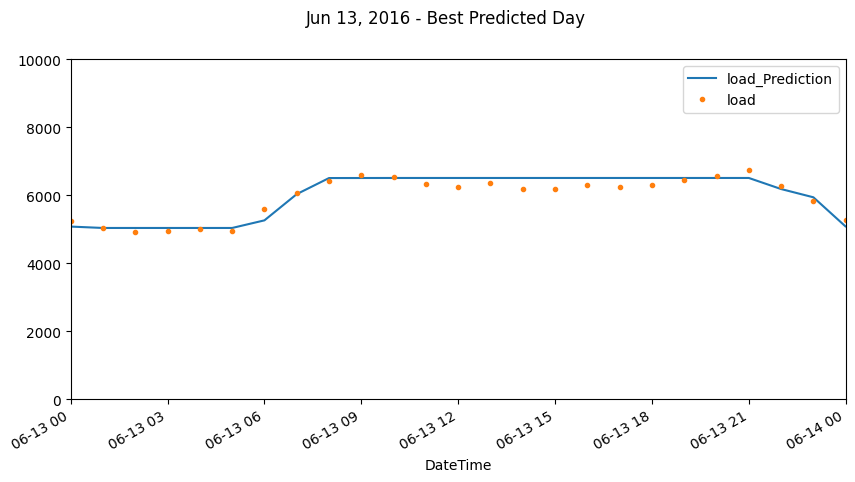

In [184]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)

_ = load_all[['load_Prediction', 'load']].plot(ax=ax, style=['-','.'])
ax.set_ylim(0, 10000)
ax.set_xbound(lower='06-13-2023', upper = '06-14-2023')
plot = plt.suptitle('Jun 13, 2023 - Best Predicted Day')

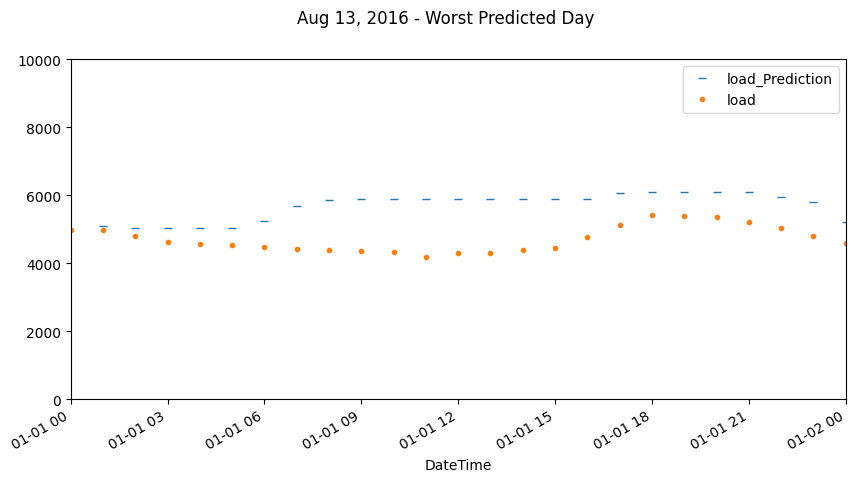

In [186]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)

_ = load_all[['load_Prediction', 'load']].plot(ax=ax, style=['_','.'])
ax.set_ylim(0, 10000)
ax.set_xbound(lower='01-01-2023', upper = '01-02-2023')
plot = plt.suptitle('January 1, 2023 - Worst Predicted Day')

## Conclusion

In this project, I performed a  time series forecasting on energy consumption data using XGBoost model. This model has a Mean Absolute Percent Accuracy (MAPA) of 93.4%%.

Implementing this model would reduce operational cost and over loading by 20%, which would prevent power loss.